# Demo of endpoint donor_distribution (part 2)

Run the module "main.py" from the base project directory with program arguments: "server <db_user> <db_password>" after replacing <db_user> and <db_password> with appropriate values.

Prepare the request parameters.
We're going to select the individuals located in the South Asian continent having mutations - as chromosome:start-alternative allele -:

1:13271-C and

1:15272-T

aligned on assembly hg19. 

For those individuals we want to know their gender, their country of origin (population) and where those samples come from (dna_source).

In [1]:
import json
param = {
    'distribute_by': [
        'gender',
        'dna_source',
        'population'
    ],
    'meta': {
        'health_status': "true",
        'super_population': ['SAS'],
        'assembly': 'hg19'
    },
    'variants': {
        'with': [{'chrom': 1, 'start': 13271, 'alt':'C'}, {'chrom': 1, 'start': 15272, 'alt': 'T'}]
    }
}
body = json.dumps(param)
print(body)

{"distribute_by": ["gender", "dna_source", "population"], "meta": {"health_status": "true", "super_population": ["SAS"], "assembly": "hg19"}, "variants": {"with": [{"chrom": 1, "start": 13271, "alt": "C"}, {"chrom": 1, "start": 15272, "alt": "T"}]}}


POST the endpoint \donor_distribution with the prepared JSON parameter

In [3]:
import requests

r = requests.post('http://127.0.0.1:5000/donor_distribution', json=param)
print(' response status code: {}'.format(r.status_code))
response_body = r.json()

response status code: 200


# Inspect response data:
It's a data cube with the numerosity of the individuals grouped on the free-dimensions: gender, dna_source and population (to be intended as country of origin)

In [6]:
import pandas as pd
from matplotlib import pyplot as plt
columns = response_body['columns']
rows = response_body['rows']
df = pd.DataFrame.from_records(rows, columns=columns)

# clean data: removes rows with dna_source = '' beacuse they're wrong; replaces None with ''
df.drop(df[df.DNA_SOURCE == ''].index, inplace=True)
df.fillna(value='', inplace=True)

df

,GENDER,DNA_SOURCE,POPULATION,count_1
0,,,,131
2,male,blood,STU,13
3,female,blood,PJL,17
4,female,blood,STU,12
5,male,blood,ITU,10
6,male,lcl,BEB,10
7,male,lcl,GIH,1
8,female,lcl,BEB,9
9,female,lcl,STU,1
10,female,blood,ITU,13


Total count of individuals

In [8]:
total = df.query('POPULATION == "" & DNA_SOURCE == "" & GENDER == ""')['count_1'].iloc[0]
print(total)

131


Distribution of samples across different regions of the SAS continent

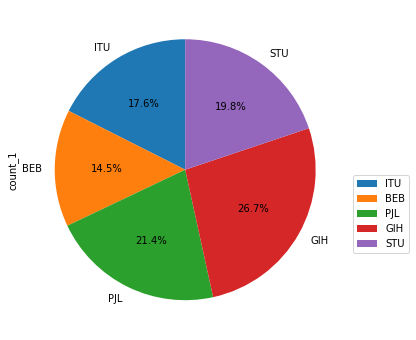

In [10]:
# to see the number of individuals in each population, we prepare an ad-hoc data structure, obtained by removing unnecessary columnms and rows form the original data source.
# unnecessary columns are gender and dna_source. Unnecessary rows, are all that ones in which dna_source or gender are != ''
df1 = df.drop(df.query('GENDER != "" | DNA_SOURCE != "" | POPULATION == ""').index)    
columns_to_drop = ['GENDER', 'DNA_SOURCE']
df1.drop(columns_to_drop, inplace=True, axis=1) # removes columns

pie = df1.plot(
    kind='pie',
    y='count_1', 
    labels=df1['POPULATION'].tolist(),
    figsize=(6, 6),
    startangle=90, 
    autopct='%1.1f%%'
)
plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.show()

Distribution of individuals by gender and population

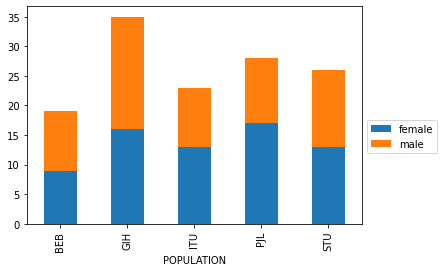

In [11]:
# prepare data frame
df2 = df.drop(df.query('GENDER == "" | POPULATION == "" | DNA_SOURCE != ""').index)    
df2.drop(['DNA_SOURCE'], inplace=True, axis=1)

df2_pivot = df2.pivot(index='POPULATION', columns='GENDER', values='count_1') # creates a df with populations as index of rows, genders as columns, n° samples as cell values
df2_pivot.plot( # automatically uses the values of index as x-axis and stacks the values of columns
    kind='bar',
    stacked=True,
    figsize=(6, 4),
)

plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.show()

Comparing these plots with the ones from the notebook samples_distribution, the two varaints 1:13271-C and 1:15272-T are more frequent in the GIH (Gujarati Indian in Houston) population than in others poulation of the South Asian continent, especially in males.